In [167]:
#
# >> imports
#

import numpy as np
import matplotlib.pyplot as plt


In [168]:
#
# >> debugs options
#

DEBUG_PHASE_0 = True
DEBUG_PHASE_1 = True
DEBUG_PHASE_2 = True
DEBUG_PHASE_3 = True
DEBUG_PHASE_4 = True
DEBUG_PHASE_5 = True
DEBUG_PHASE_6 = True
DEBUG_PHASE_7 = True


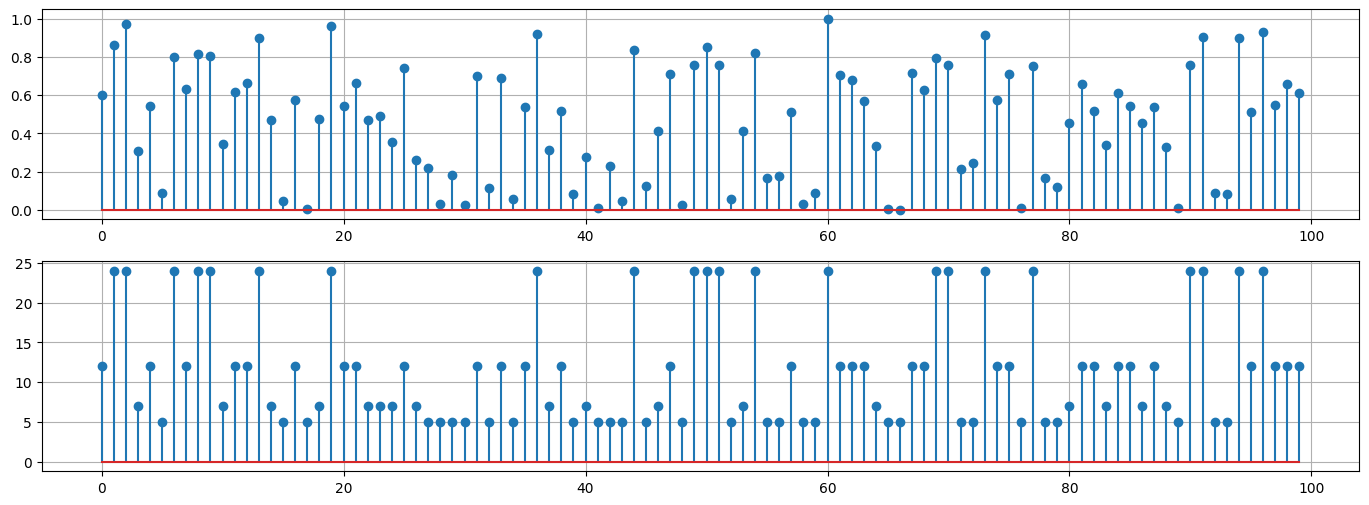

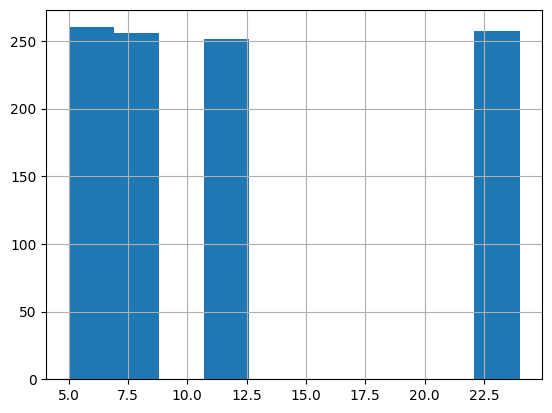

In [169]:
#
# >> hypothesis generator phase
#

HYPOTHESIS = [5, 7, 12, 24]
PROBABILITIES = [0.25, 0.25, 0.25, 0.25]
N_SAMPLES = 2**10

#
# >> generation of the hypothesis
#

z = np.random.uniform(size=N_SAMPLES)       # generates a vector of random numbers between 0 and 1
hypothesis = np.full(N_SAMPLES, 0)          # initialize the final hypothesis vector
for i in range(N_SAMPLES):                  # iterate N_SAMPLES times
    j = 0                                   # store the index of the hypothesis to be used
    accumulator = PROBABILITIES[j]          # initialize the accumulator
    while accumulator < z[i]:               # if the accumulator stills below of the generated random number, add the next probability
        j += 1                              # move to the next index of the hypothesis vector
        accumulator += PROBABILITIES[j]     # accumulate the next probability
    hypothesis[i] = HYPOTHESIS[j]           # store the final hypothesis, associated to the random number generated

#
# >> DEBUG
#

if DEBUG_PHASE_0:

    plt.figure(figsize=(17, 3 * 2))

    plt.subplot(2, 1, 1)
    plt.stem(z[0:100])
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.stem(hypothesis[0:100])
    plt.grid(True)

    plt.show(True)

    plt.hist(hypothesis)
    plt.grid(True)

    plt.show(True)


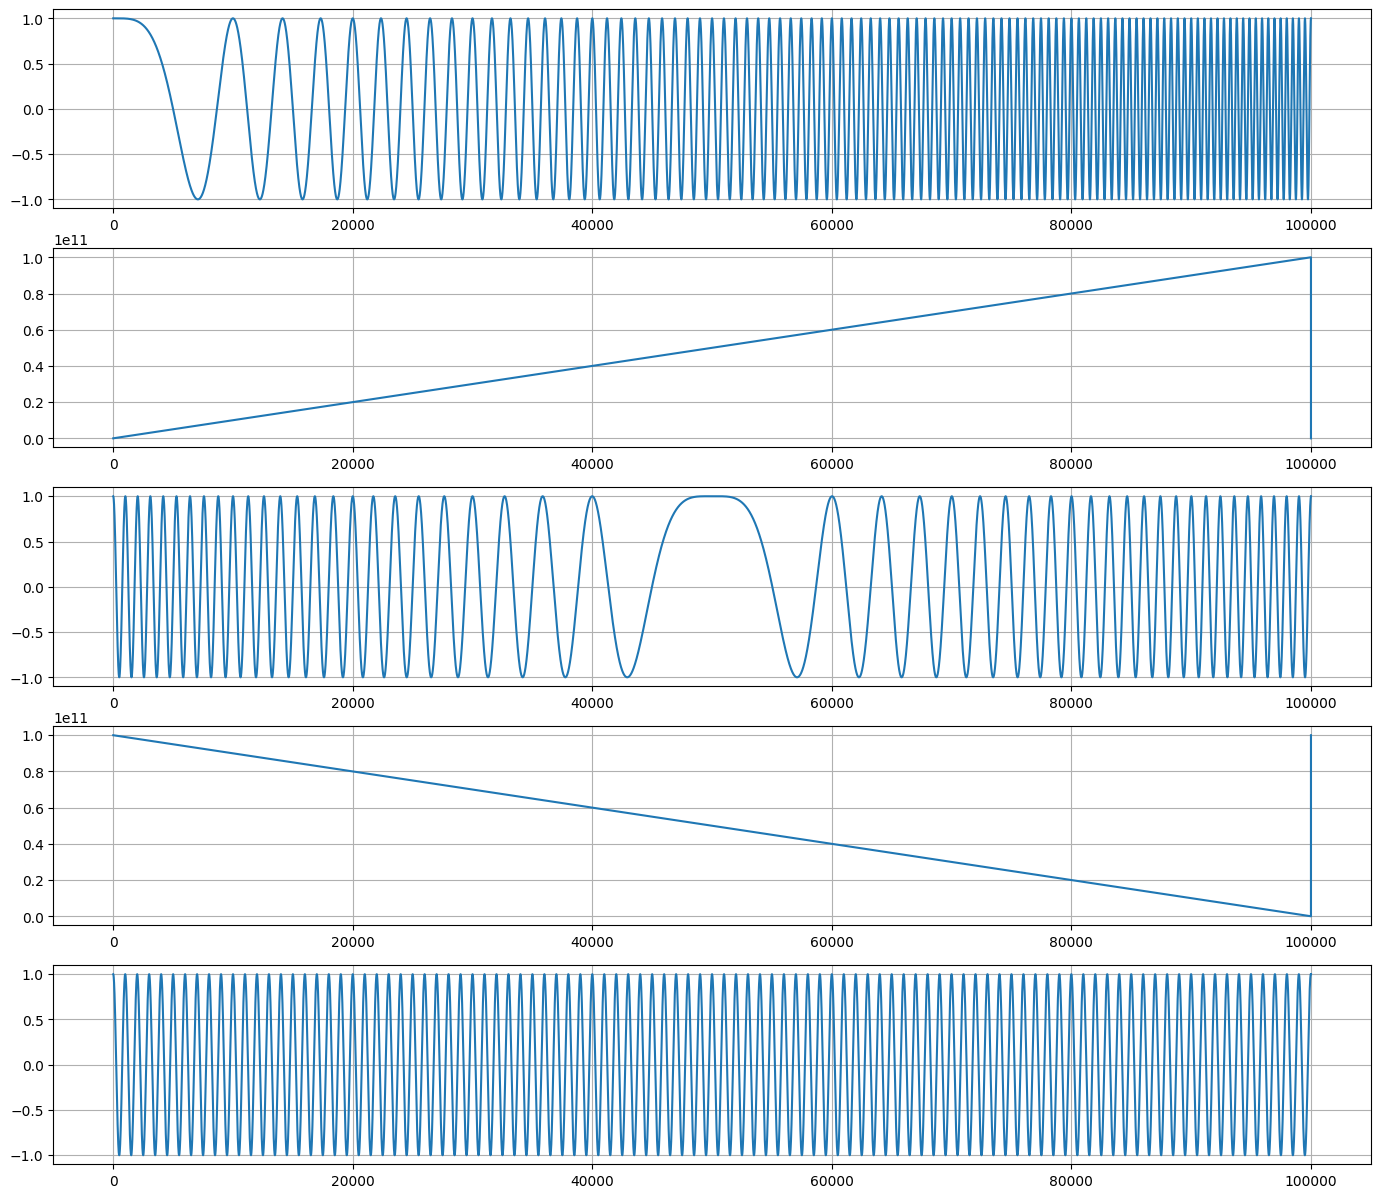

In [170]:
#
# >> base function generation phase
#

T = 10e-10          # period in [s]
LOW_FREQ = 10e6     # start frequency of the base function in [Hz]
HIGH_FREQ = 10e10   # end frequncy of the base function in [Hz]

def complexExp(time, freq, alpha=1):
    return alpha * np.exp(1j * 2 * np.pi * freq * time)

# return a pair with the value in time and the value of the frequency
# in a certain time, based on the base function, simulating a LoRa modulation up-chirp
def upChirp(time):
    c = (HIGH_FREQ - LOW_FREQ) / T
    freq = (c * time + LOW_FREQ) % HIGH_FREQ
    signal = complexExp(time % T, freq)
    return signal, freq

# return a pair with the value in time and the value of the frequency
# in a certain time, based on the base function, simulating a LoRa modulation down-chirp
def downChirp(time):
    c = (HIGH_FREQ - LOW_FREQ) / T
    freq = HIGH_FREQ - c * (time % T)
    signal = complexExp(time % T, freq)
    return signal, freq

#
# >> DEBUG
#

if DEBUG_PHASE_1:

    time = np.linspace(0, 1 * T, 100000)
    up_chirp_results = upChirp(time)
    down_chirp_results = downChirp(time)

    plt.figure(figsize=(17, 3 * 5))

    plt.subplot(5, 1, 1)
    plt.plot(up_chirp_results[0])
    plt.grid(True)

    plt.subplot(5, 1, 2)
    plt.plot(up_chirp_results[1])
    plt.grid(True)

    plt.subplot(5, 1, 3)
    plt.plot(down_chirp_results[0])
    plt.grid(True)
    
    plt.subplot(5, 1, 4)
    plt.plot(down_chirp_results[1])
    plt.grid(True)

    plt.subplot(5, 1, 5)
    plt.plot(up_chirp_results[0] * down_chirp_results[0])
    plt.grid(True)

    plt.show(True)


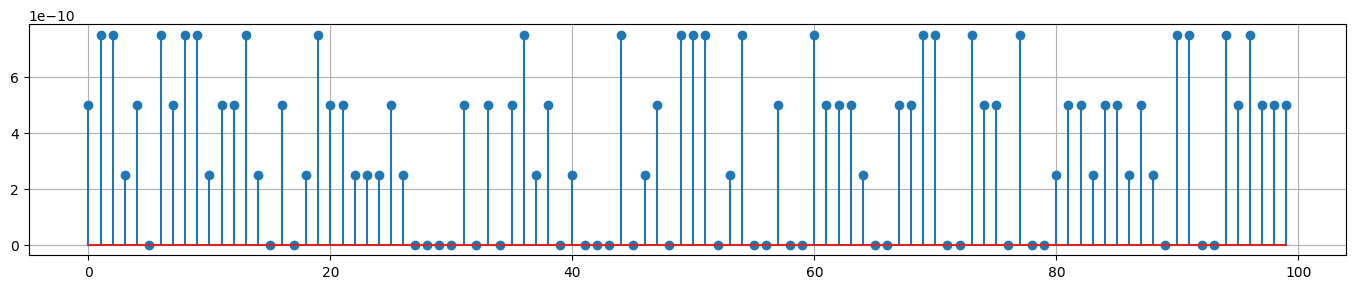

In [171]:
#
# >> encoder codeword output phase
#

CODEWORDS_DELTA_TIME = T / len(HYPOTHESIS)
CODEWORDS = []

#
# >> generation of the codewords
#

for i in range(len(HYPOTHESIS)):
    CODEWORDS.append(CODEWORDS_DELTA_TIME * i)

codewords = []

for it in hypothesis:
    for i in range(len(HYPOTHESIS)):
        if it == HYPOTHESIS[i]:
            codewords.append(CODEWORDS[i])

#
# >> DEBUG
#

if DEBUG_PHASE_2:

    plt.figure(figsize=(17, 3 * 1))

    plt.stem(codewords[0:100])
    plt.grid(True)
    plt.show(True)


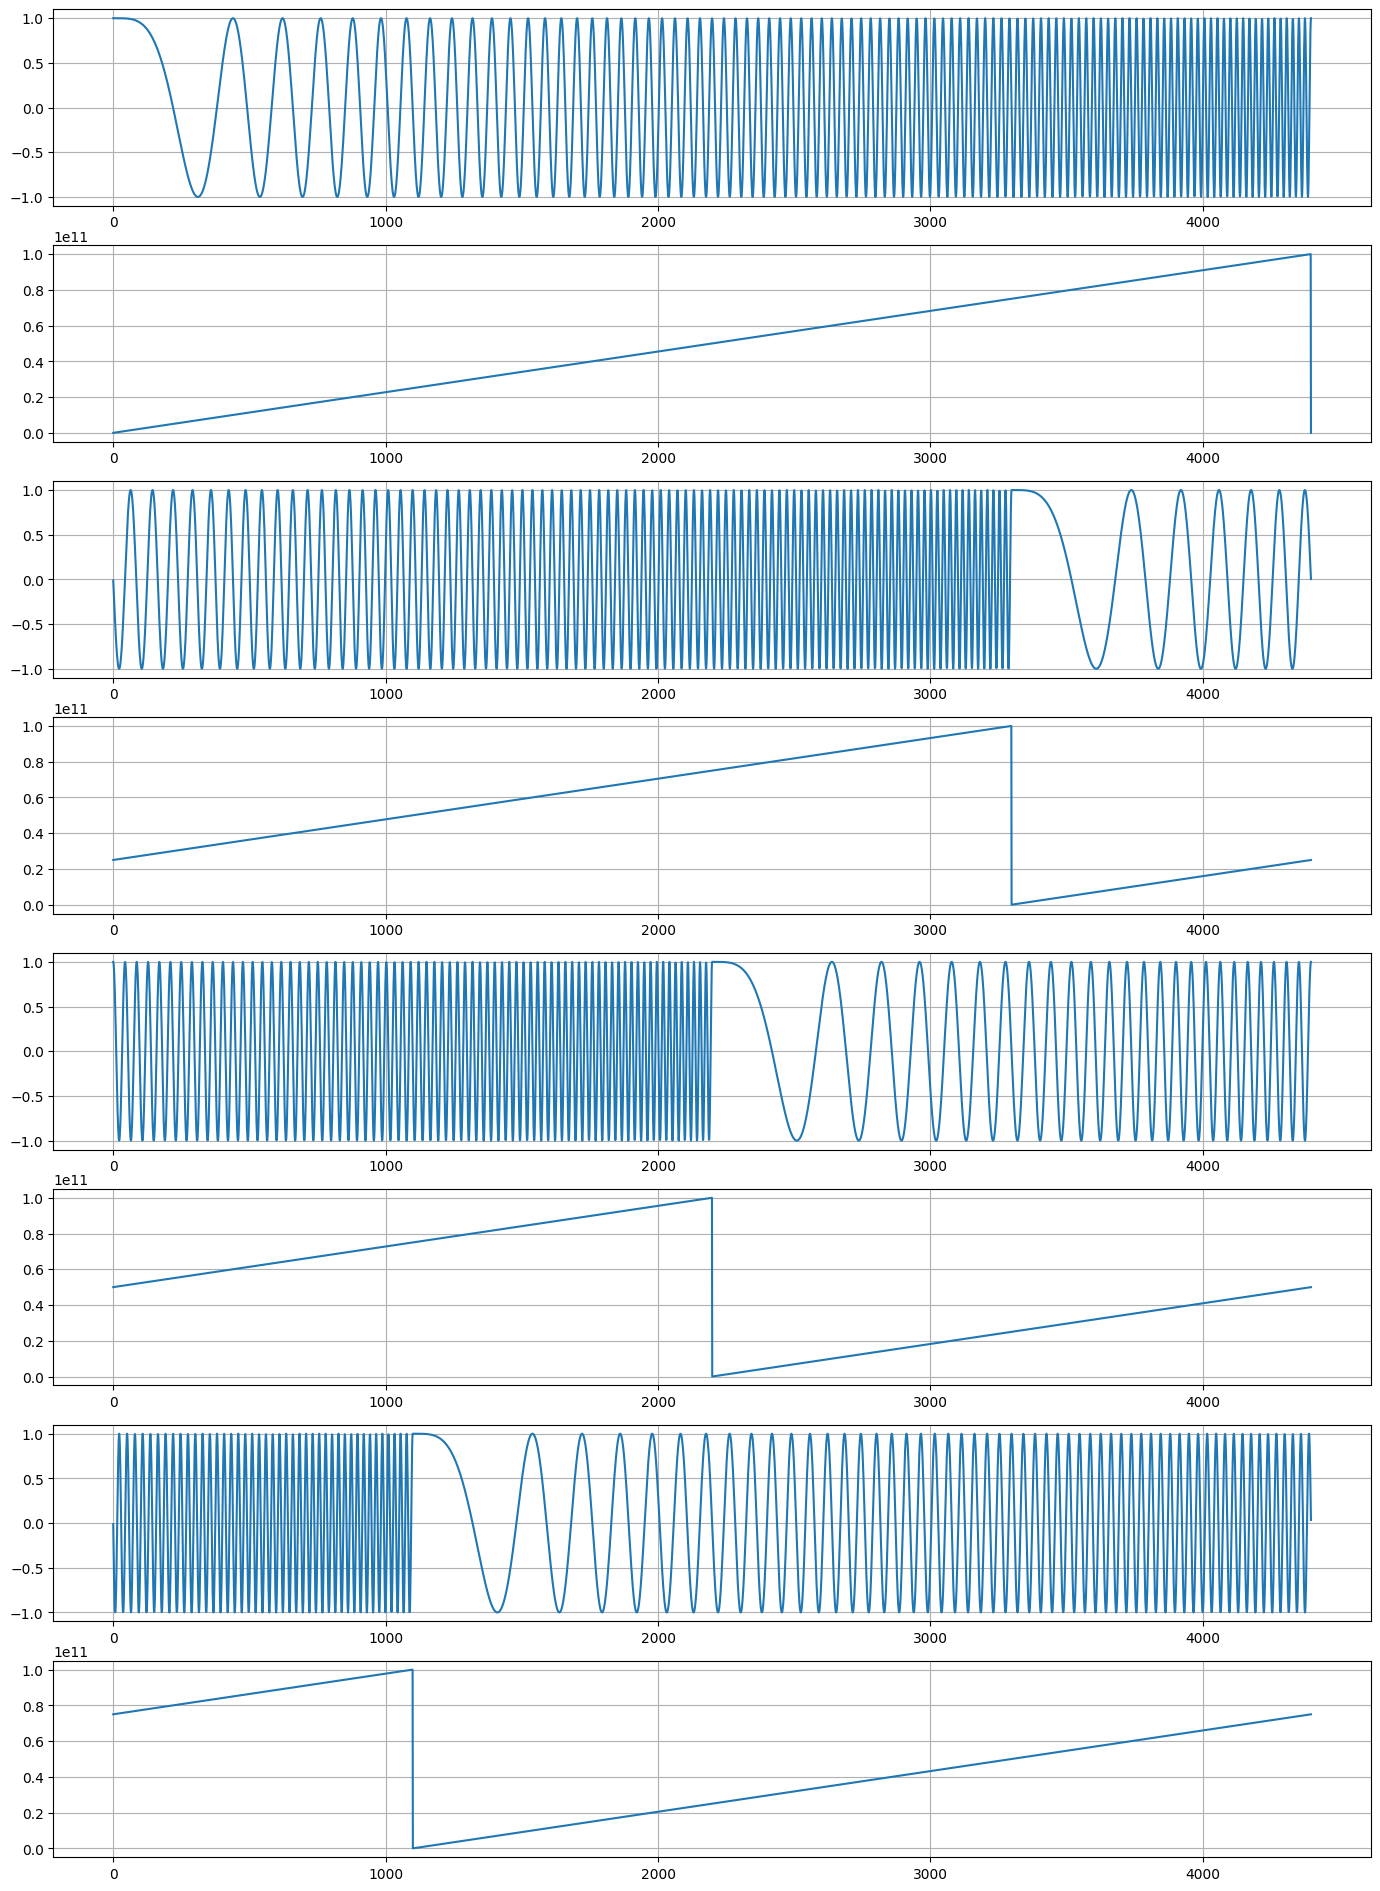

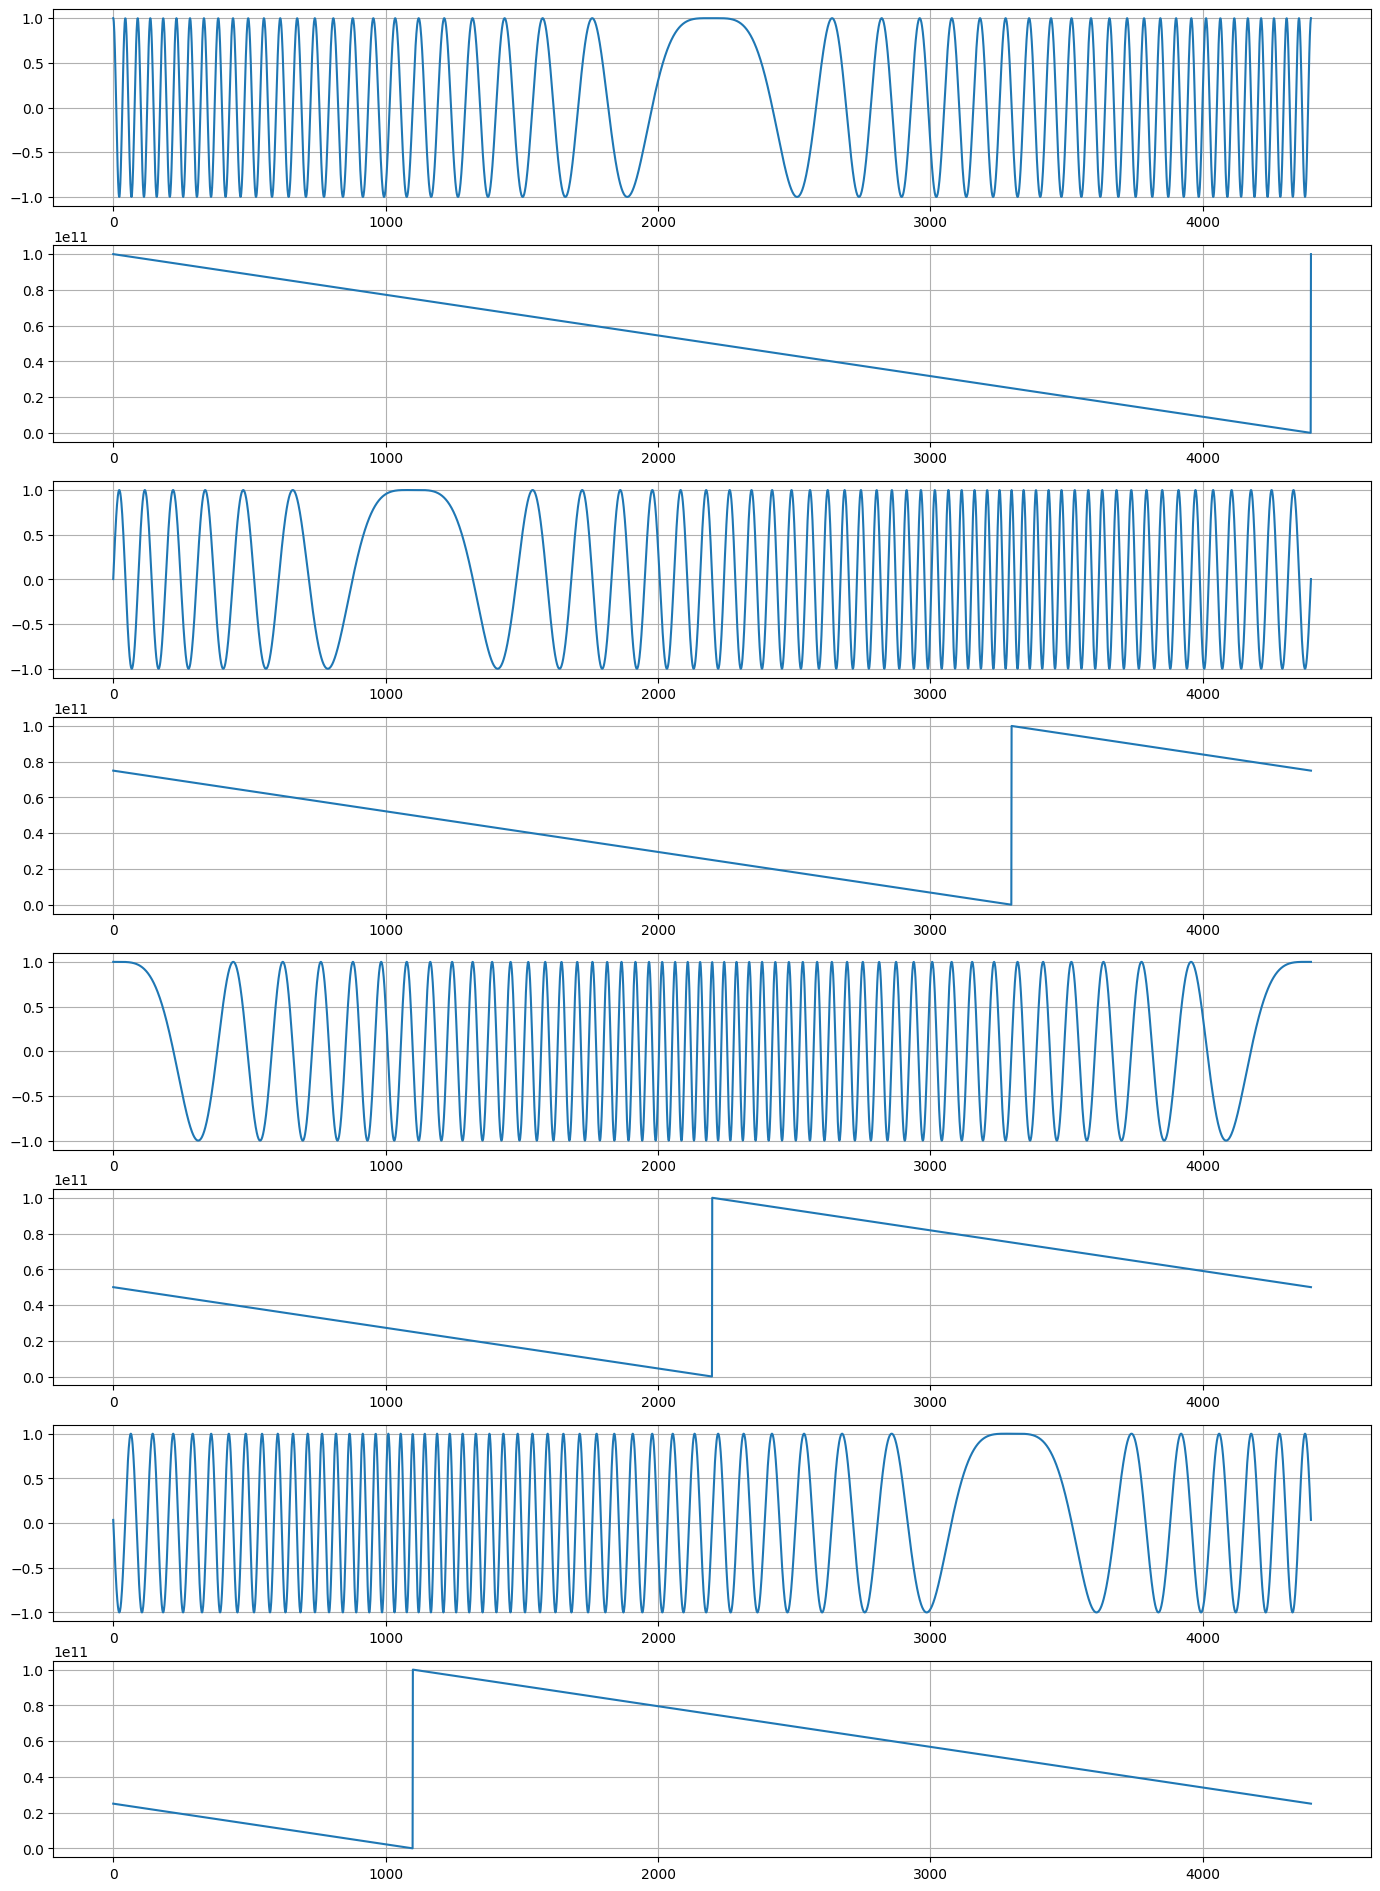

In [172]:
#
# >> waveform former function phase
#

SAMPLING_RATE = 2**42               # samples per second [samples / s]
SPS = int(SAMPLING_RATE * T)        # samples per symbol [samples / symbol]
T_TIME = np.linspace(0, T, SPS)     # time vector of a period, with a total of samples per symbol elements
UP_CHIRPS = []                      # up-chirp values based on the time vector of a period of the symbol
DOWN_CHIRPS = []                    # down-chirp values based on the time vector of a period of the symbol

for it in CODEWORDS:
    UP_CHIRPS.append(upChirp(T_TIME + it))

for it in CODEWORDS:
    DOWN_CHIRPS.append(downChirp(T_TIME + it))

# returns an array of the first array of each element
# [[[a, a, ...], [b, b, ...]], [[c, c, ...], [d, d, ...]]] returns [a, a, ..., c, c, ...]
def timeWaveform(arrays):
    return [item for array in arrays for item in array[0]]

# returns an array of the first array of each element
# [[[a, a, ...], [b, b, ...]], [[c, c, ...], [d, d, ...]]] returns [a, a, ..., c, c, ...]
def freqWaveform(arrays):
    return [item for array in arrays for item in array[1]] 

# returns the complete up-chirp waveform based on the codewords array
def generateUpChirp(codewords):
    output = []
    for it in codewords:
        for i in range(len(CODEWORDS)):
            if CODEWORDS[i] == it:
                output.append(UP_CHIRPS[i])
                break
    return [timeWaveform(output), freqWaveform(output)]

# returns the complete down-chirp waveform based on the codewords array
def generateDownChirp(codewords):
    output = []
    for it in codewords:
        for i in range(len(CODEWORDS)):
            if CODEWORDS[i] == it:
                output.append(DOWN_CHIRPS[i])
                break
    return [timeWaveform(output), freqWaveform(output)]

#
# >> DEBUG
#

if DEBUG_PHASE_3:

    plt.figure(figsize=(17, 3 * len(UP_CHIRPS) * 2))
    i = 1

    for it in UP_CHIRPS:

        plt.subplot(len(UP_CHIRPS) * 2, 1, i)
        plt.plot(it[0])
        plt.grid(True)

        plt.subplot(len(UP_CHIRPS) * 2, 1, i + 1)
        plt.plot(it[1])
        plt.grid(True)

        i += 2

    plt.show(True)
    plt.figure(figsize=(17, 3 * len(DOWN_CHIRPS) * 2))
    i = 1

    for it in DOWN_CHIRPS:

        plt.subplot(len(DOWN_CHIRPS) * 2, 1, i)
        plt.plot(it[0])
        plt.grid(True)

        plt.subplot(len(DOWN_CHIRPS) * 2, 1, i + 1)
        plt.plot(it[1])
        plt.grid(True)

        i += 2
    
    plt.show(True)


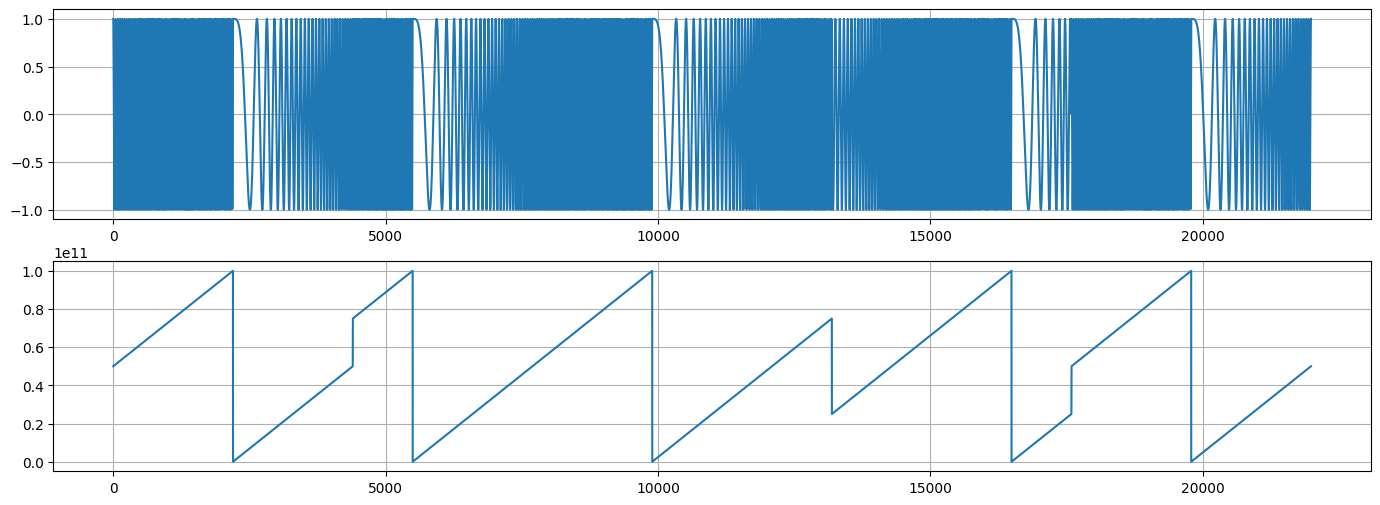

In [173]:
#
# >> waveform generation phase
#

waveform = generateUpChirp(codewords)

if DEBUG_PHASE_4:

    plt.figure(figsize=(17, 3 * 2))

    plt.subplot(2, 1, 1)
    plt.plot(waveform[0][0:SPS * 5])
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(waveform[1][0:SPS * 5])
    plt.grid(True)
    
    plt.show(True)


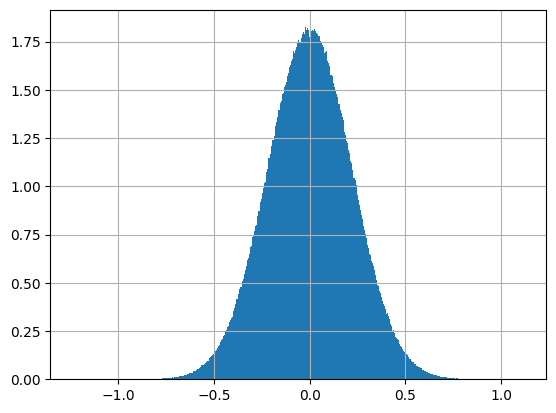

In [174]:
#
# >> additive white gaussian noise generator phase
#

MEAN = 0
STD_DEV = 0.22

simulated_noise = np.random.normal(MEAN, STD_DEV, len(waveform[0]))

#
# >> DEBUG
#

if DEBUG_PHASE_5:

    plt.hist(simulated_noise, bins=1000, density=True)
    plt.grid(True)
    plt.show(True)


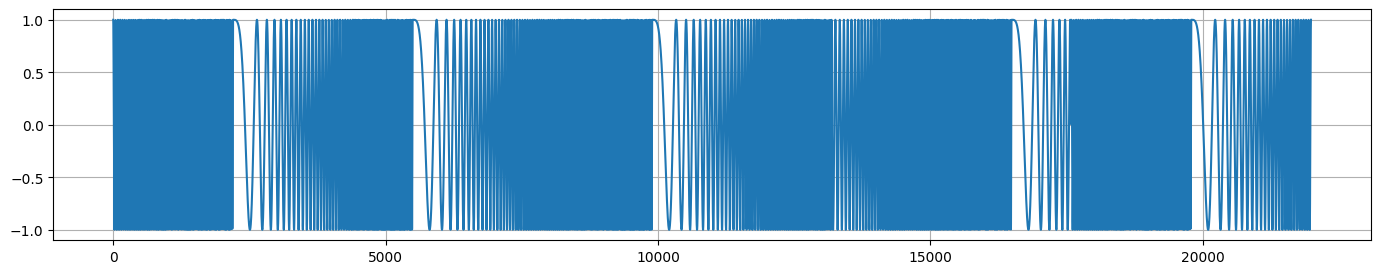

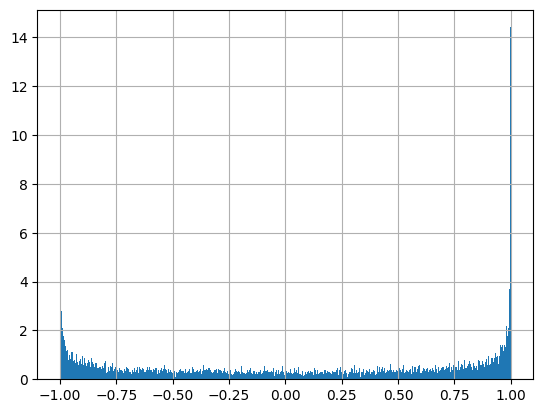

In [175]:
#
# >> transmission of the signal over the AWGN channel phase
#

LOOPBACK = True

if LOOPBACK:
    transmitted_signal = waveform[0]
else:
    transmitted_signal = waveform[0] + simulated_noise

#
# >> DEBUG
#

if DEBUG_PHASE_6:

    plt.figure(figsize=(17, 3))

    plt.plot(transmitted_signal[0:SPS * 5])
    plt.grid(True)
    
    plt.show(True)

    plt.hist(transmitted_signal, bins=1000, density=True)
    plt.grid(True)

    plt.show(True)


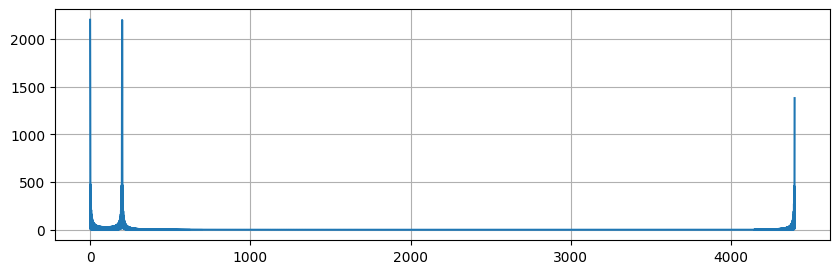

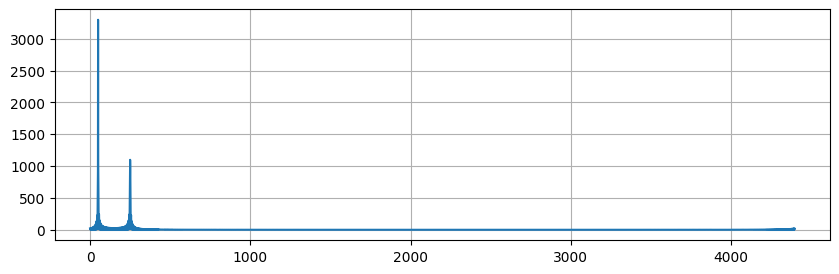

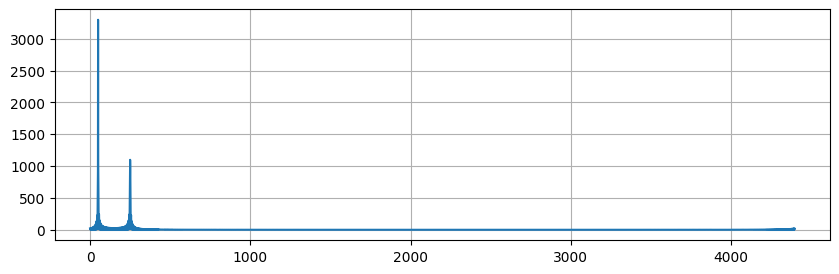

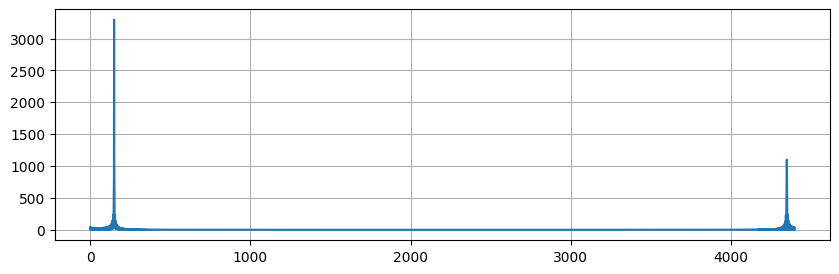

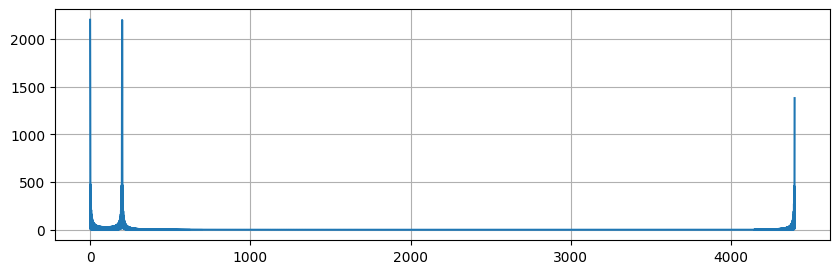

c:\Users\juanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\juanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


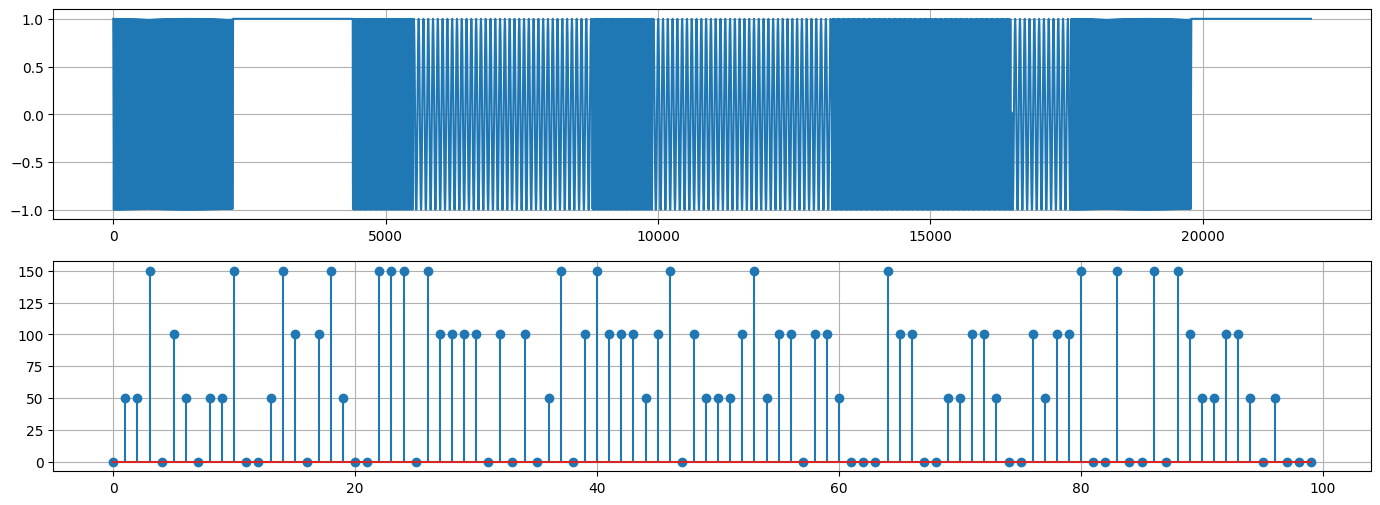

In [179]:
#
# >> n-tuple former phase
#

received_signal = transmitted_signal
estimated_symbols = []

for i in range(int(len(received_signal) / SPS)):
    signal_tmp = received_signal[i * SPS:(i + 1) * SPS]
    signal_tmp = signal_tmp * downChirp(T_TIME)[0]
    fft_signal_tmp = np.abs(np.fft.fft(signal_tmp))
    estimated_symbols.append(np.argmax(fft_signal_tmp))

    if i < 5:
        plt.figure(figsize=(10,3))
        plt.plot(fft_signal_tmp)
        plt.grid(True)
        plt.show(True)

error_count = 0
for i in range(len(estimated_symbols)):
    if estimated_symbols[i] != codewords[i]:
        error_count += 1

#
# >> DEBUG
#

if DEBUG_PHASE_7:

    plt.figure(figsize=(17, 3 * 2))

    plt.subplot(2, 1, 1)
    plt.plot(received_signal[0:SPS * 5])
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.stem(estimated_symbols[0:100])
    plt.grid(True)

    plt.show(True)
